In [28]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from Exercise1_1 import LQRSolver
from torch.utils.data import TensorDataset, DataLoader

from matplotlib import rcParams
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

# Define matrices for LQR problem
H = torch.tensor([[1.2, 0.8], [-0.6, 0.9]], dtype=torch.double)
M = torch.tensor([[0.5,0.7], [0.3,1.0]], dtype=torch.double)
sigma = torch.tensor([[[0.8],[1.1]]], dtype=torch.double)
C = torch.tensor([[1.6, 0.0], [0.0, 1.1]], dtype=torch.double)
D = torch.tensor([[0.5, 0.0], [0.0, 0.7]], dtype=torch.double)
R = torch.tensor([[0.9, 0.0], [0.0, 1.0]], dtype=torch.double)
T = torch.tensor(1.0, dtype=torch.double)

# Initialize LQRSolver
lqr_solver = LQRSolver(H, M, sigma, C, D, R, T=T, method="euler")


In [3]:
# Function of generating a new batch of training data

def new_data(num_samples,func_to_cal):
    #num_samples = 10000
    t_samples = T * torch.rand(num_samples, dtype=torch.double)
    x_ends = torch.tensor([-3,3], dtype = torch.double)
    x_samples = x_ends[0] + (x_ends[1]- x_ends[0]) * torch.rand(num_samples, 1, 2, dtype=torch.double)
    if func_to_cal == 'value':
        v_samples = lqr_solver.value_function(t_samples, x_samples)
        return t_samples,x_samples,v_samples
    if func_to_cal == 'control':
        alpha_samples = lqr_solver.markov_control(t_samples, x_samples)
        return t_samples,x_samples,alpha_samples

In [16]:
# Neural network for value function approximation
class ValueFunctionNN(nn.Module):
    def __init__(self):
        super(ValueFunctionNN, self).__init__()
        #self.hidden = nn.Linear(3, 100)
        self.layer1 = nn.Linear(3, 100)  
        self.layer2 = nn.Linear(100, 100)
        self.layer3 = nn.Linear(100, 100)
        self.layer4 = nn.Linear(100, 100)
        self.relu = nn.ReLU()
        self.output = nn.Linear(100, 1)
    
    def forward(self, x):
        #x = self.relu(self.hidden(x))
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        return self.output(x)
        

In [17]:
# New model
model_value = ValueFunctionNN().double()

# Prepare for training
optimizer_value = torch.optim.Adam(model_value.parameters(), lr=0.001)
criterion_value = nn.MSELoss()

# List to store loss per epoch for plotting
epoch_losses = []

# Training batch 5
batch_size = 5
epochs = 1000

for batch in range(batch_size):

    print(f'Batch {batch+1}/{batch_size}'+'\n')
    t_data,x_data,v_data = new_data(10000,'value')

    inputs = torch.cat((t_data.unsqueeze(-1), x_data.squeeze(1)), dim=1)
    dataset = TensorDataset(inputs, v_data)
    dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

    for epoch in range(epochs):
        model_value.train()
        total_loss = 0
        for batch_idx, (data, target) in enumerate(dataloader):
            optimizer_value.zero_grad()
            output = model_value(data)
            loss = criterion_value(output, target.unsqueeze(1))
            loss.backward()
            optimizer_value.step()
            total_loss += loss.item()
            
        epoch_losses.append(total_loss / len(dataloader))  # Store average loss for this epoch
        if epoch == 0:
            print(f'Epoch {epoch+1}/{epochs} \t Loss: {total_loss / len(dataloader)}')
        if (epoch+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs} \t Loss: {total_loss / len(dataloader)}')
    print('\n')

Batch 1/5

Epoch 1/1000 	 Loss: 474.6963688912839
Epoch 100/1000 	 Loss: 0.07129181577035114
Epoch 200/1000 	 Loss: 0.029353964893648343
Epoch 300/1000 	 Loss: 0.02314420510453869
Epoch 400/1000 	 Loss: 0.012941378216202717
Epoch 500/1000 	 Loss: 0.017820281901868223
Epoch 600/1000 	 Loss: 0.009909450806324029
Epoch 700/1000 	 Loss: 0.03323005426462546
Epoch 800/1000 	 Loss: 0.03958130279295878
Epoch 900/1000 	 Loss: 0.0057465806785819825
Epoch 1000/1000 	 Loss: 0.007272321731372525


Batch 2/5

Epoch 1/1000 	 Loss: 0.009745473164413744
Epoch 100/1000 	 Loss: 0.007470100992403475
Epoch 200/1000 	 Loss: 0.012661062140877513
Epoch 300/1000 	 Loss: 0.007027785894125414
Epoch 400/1000 	 Loss: 0.0944164259160184
Epoch 500/1000 	 Loss: 0.010982112355755826
Epoch 600/1000 	 Loss: 0.010285633158816544
Epoch 700/1000 	 Loss: 0.004041519663357835
Epoch 800/1000 	 Loss: 0.030949904260964646
Epoch 900/1000 	 Loss: 0.0034364631041358014
Epoch 1000/1000 	 Loss: 0.008944549436860015


Batch 3/5

Epoc

/var/folders/b6/kmqmc4952k7__8jzcqjy4jn00000gn/T/ipykernel_39619/1592802108.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(min(epoch_losses)- 0.01, max(epoch_losses) + 0.01)  # Setting the y-axis limit to better visualize the decrease in loss
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


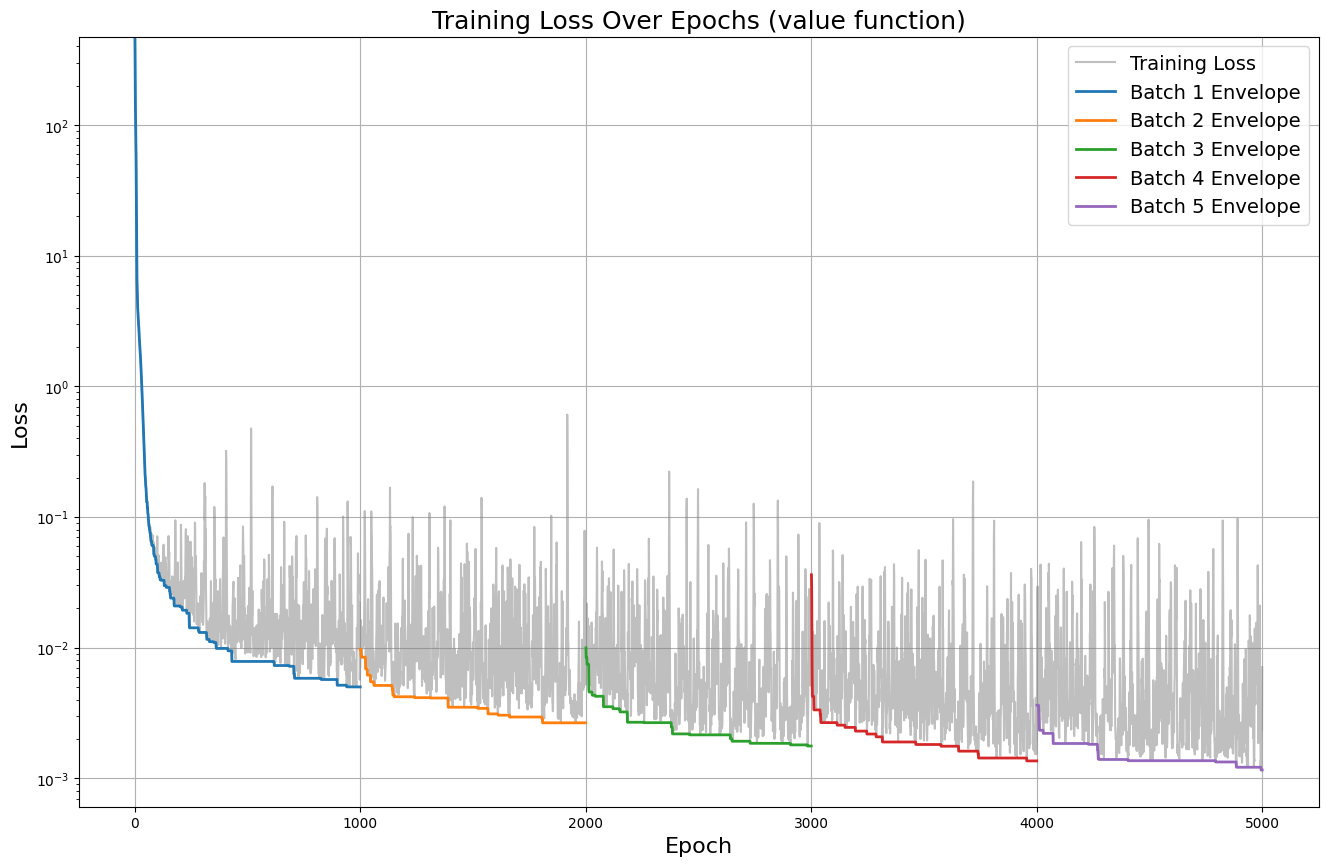

In [18]:
# Plotting the training loss with adjusted y-axis limits

envelope_lower = np.minimum.accumulate(epoch_losses)
plt.figure(figsize=(16, 10))
plt.plot(epoch_losses, label='Training Loss', alpha=0.5, color='grey')
epoch_list = range(batch_size*epochs)
for i in range(batch_size):
    start = i * epochs
    end = (i + 1) * epochs
    batch_epochs = epoch_list[start:end]
    batch_losses = epoch_losses[start:end]
    
    envelope_lower = np.minimum.accumulate(batch_losses)
    
    plt.plot(batch_epochs, envelope_lower, label=f'Batch {i+1} Envelope',lw=2)


plt.yscale('log')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Training Loss Over Epochs (value function)', fontsize=18)
plt.ylim(min(epoch_losses)- 0.01, max(epoch_losses) + 0.01)  # Setting the y-axis limit to better visualize the decrease in loss
plt.legend(fontsize=14)
plt.grid(True)  # Add grid for better readability

plt.savefig('Training Loss (value function).eps', format='eps', dpi=600)
plt.savefig('Training Loss (value function).png', format='png', dpi=600)

plt.show()

In [19]:
torch.save(model_value, 'value_model.pth')

In [11]:
#Visualization

t_ends = [0.1,0.9]
t_num = 9
x_ends = [[-3,3],[-3,3]]
x_num = [144,144]

t_batch_i = torch.linspace(t_ends[0],t_ends[1],t_num,dtype=torch.double)
t_batch = t_batch_i.repeat_interleave(x_num[0]*x_num[1])

x1 = torch.linspace(x_ends[0][0],x_ends[0][1],x_num[0],dtype=torch.double)
x2 = torch.linspace(x_ends[1][0],x_ends[1][1],x_num[1],dtype=torch.double)

x_batch_i = torch.cartesian_prod(x1, x2).unsqueeze(1)

X1 = x_batch_i[:, 0, 0].view(x_num[0], x_num[1])
X2 = x_batch_i[:, 0, 1].view(x_num[0], x_num[1])

x_batch = torch.cartesian_prod(x1, x2).unsqueeze(1).repeat(t_num, 1, 1)

value_numerical = lqr_solver.value_function(t_batch,x_batch)

In [20]:
model_value.eval()
value_nn = (model_value(torch.cat((t_batch.unsqueeze(-1), x_batch.squeeze(1)), dim=1))).squeeze()

ValueFunctionNN(
  (layer1): Linear(in_features=3, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=100, bias=True)
  (layer4): Linear(in_features=100, out_features=100, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=100, out_features=1, bias=True)
)

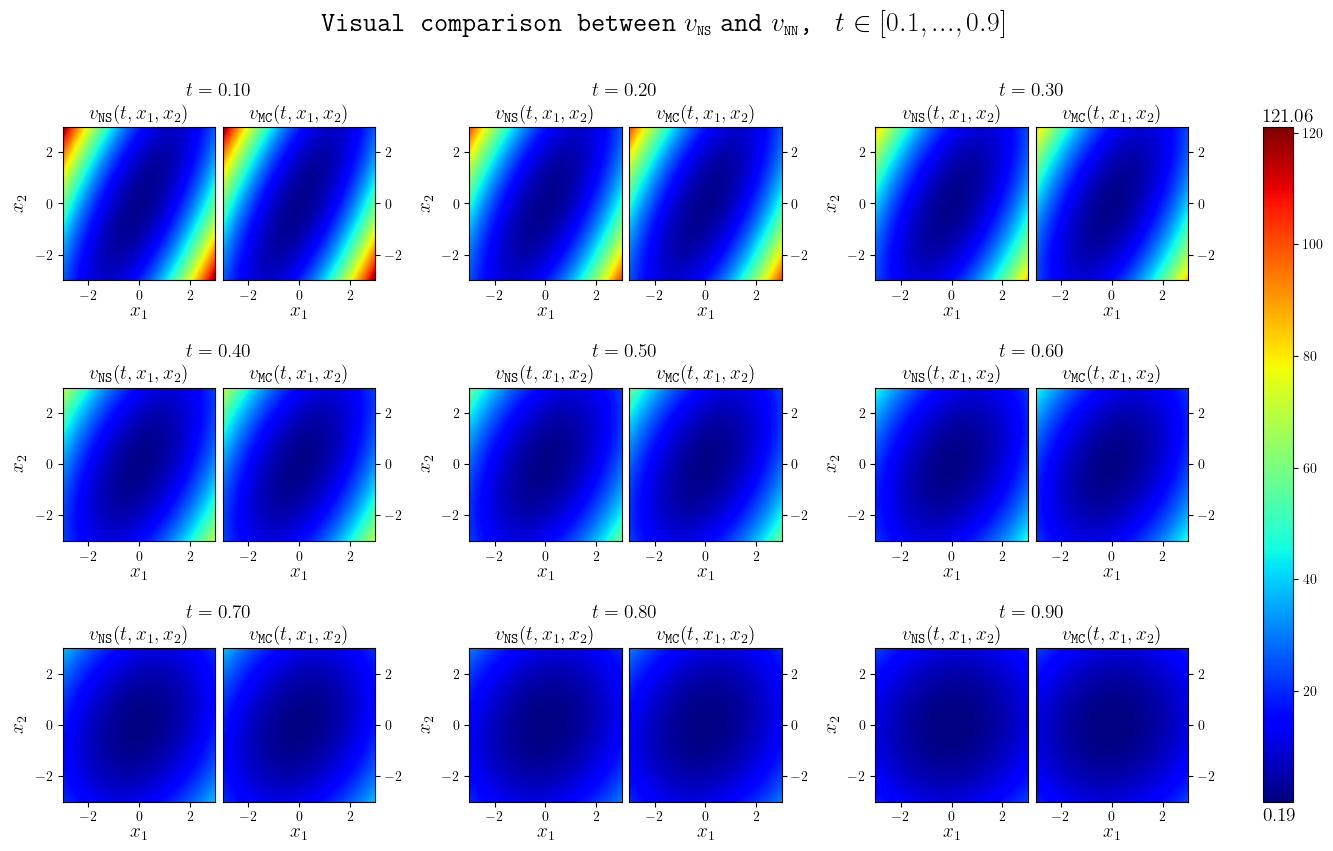

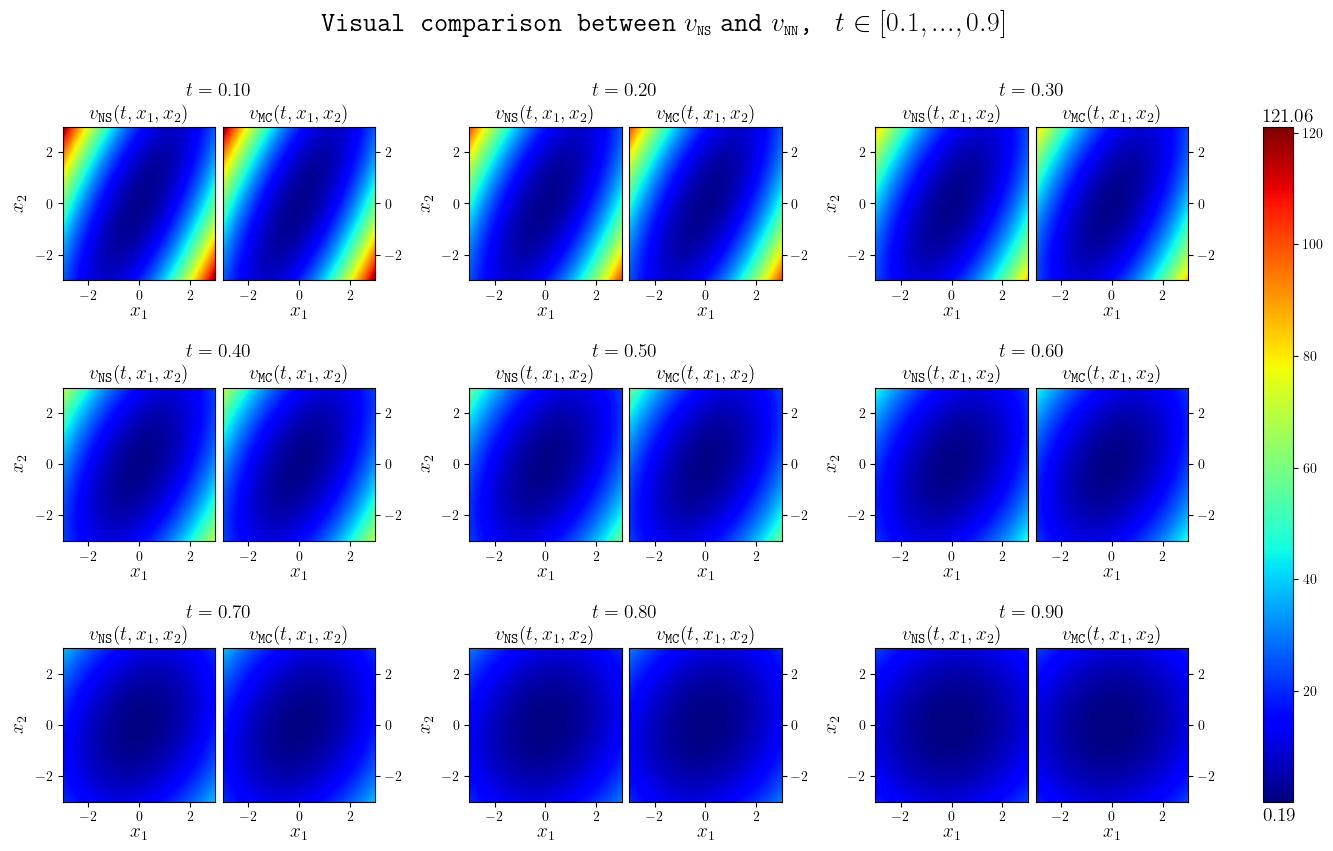

In [31]:
#Visualization

value_numerical_reshape = value_numerical.reshape([t_num,x_num[0]*x_num[1]]).view(t_num, x_num[0], x_num[1])
value_nn_reshape = value_nn.reshape([t_num,x_num[0]*x_num[1]]).view(t_num, x_num[0], x_num[1])

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{tgschola}')
value_min = torch.min(torch.cat((value_numerical,value_nn),dim = 0)).detach().numpy()
value_max = torch.max(torch.cat((value_numerical,value_nn),dim = 0)).detach().numpy()

fig = plt.figure(figsize=(15, 9))
#创建 3x3 的 GridSpec，每个元素再分成 1x2 的子 GridSpec
gs = gridspec.GridSpec(3, 3)

cmap = 'jet'
plt.subplots_adjust(left=0.1, right=0.85, bottom=0.1, top=0.85, wspace=0.3, hspace=0.7)
for i in range(len(t_batch_i)):  # 假设一共有 9 组数据
    # 对于每个 GridSpec 位置创建 1x2 的 SubGridSpec
    subgs = gs[i // 3, i % 3].subgridspec(1, 2, wspace=0.05)
    # 左子图
    ax_left = fig.add_subplot(subgs[0, 0])
    ax_left.contourf(X1.detach().numpy(), X2.detach().numpy(), value_numerical_reshape[i].detach().numpy(), levels=500, cmap=cmap, vmin=value_min, vmax=value_max)
    ax_left.set_title(r'$v_{\normalsize\texttt{NS}} (t,x_1,x_2)$', fontsize=14)
    ax_left.set_xlabel(r'$x_1$', labelpad=0, fontsize=14)
    ax_left.set_ylabel(r'$x_2$', labelpad=6, fontsize=14)
    
    # 右子图，使用相同的索引i来模拟新数据
    ax_right = fig.add_subplot(subgs[0, 1])
    # 假设 value_numerical_reshape_new 是新数据，你需要替换成实际数据
    ax_right.contourf(X1.detach().numpy(), X2.detach().numpy(), value_nn_reshape[i].detach().numpy(), levels=500, cmap=cmap, vmin=value_min, vmax=value_max)
    ax_right.set_title(r'$v_{\normalsize\texttt{MC}}(t,x_1,x_2)$', fontsize=14)
    ax_right.set_xlabel(r'$x_1$', labelpad=0, fontsize=14)
    ax_right.tick_params(left=False)
    ax_right.tick_params(labelleft=False)
    ax_right.tick_params(right=True)
    ax_right.tick_params(labelright=True)
    #ax_right.set_ylabel(r'$x_2$', labelpad=6, fontsize=14)
    pos_left = ax_left.get_position()
    pos_right = ax_right.get_position()

    # 计算中间位置的x坐标
    middle_x = (pos_left.x1 + pos_right.x0) / 2
    group_title = fr"$t = {{{t_batch_i[i]:.2f}}}$"
    fig.text(middle_x, pos_left.y1 + 0.03, group_title, ha='center', va='bottom', fontsize=14)


# x_positions = [0.17, 0.5, 0.83]  # 可能需要调整这些值以适应你的布局
# for i in range(3):
#     for j in range(3):
#         group_title = f"Group {i*3 + j + 1}: t = {t_batch_i[i*3 + j]:.2f}"
#         plt.figtext(x_positions[j], 0.88 - i*0.32, group_title, ha='center', fontsize=12)

cbaxes = fig.add_axes([0.90, 0.1, 0.02, 0.75])
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=value_min, vmax=value_max), cmap=cmap), cax=cbaxes, orientation='vertical')
cbar_ax_pos = cbar.ax.get_position()

text_x = cbar_ax_pos.x0 
text_y_min = cbar_ax_pos.y0  
text_y_max = cbar_ax_pos.y0 + cbar_ax_pos.height  

fig.text(text_x, text_y_min-0.025, fr'${{{value_min:.2f}}}$', va='bottom', ha='left',fontsize=14)
fig.text(text_x, text_y_max+0.02, fr'${{{value_max:.2f}}}$', va='top', ha='left',fontsize=14)


fig.suptitle(r'{\rmfamily {\texttt{Visual comparison between}}  $v_{\normalsize \texttt{NS}}$ {\texttt{and}} $v_{\normalsize\texttt{NN}} ${\texttt{,  }}   $t \in [0.1,...,0.9]$}',fontsize=20)
# plt.show()
display(fig)

plt.savefig('Exercise2_1_'+f'Comparion_over_time_horizon_{x_num[0]}x{x_num[1]}.eps', format='eps', dpi=600)
plt.savefig('Exercise2_1_'+f'Comparion_over_time_horizon_{x_num[0]}x{x_num[1]}.png', format='png', dpi=600)

In [8]:
class MarkovControlNN(nn.Module):
    def __init__(self):
        super(MarkovControlNN, self).__init__()
        self.layer1 = nn.Linear(3, 100)  
        self.layer2 = nn.Linear(100, 100)  
        self.relu = nn.ReLU()
        self.output = nn.Linear(100, 2) 
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        return self.output(x)


In [9]:
# Initialize the model
model_control = MarkovControlNN().double()  # Use double precision to match input data type

# Training settings
optimizer_control = torch.optim.Adam(model_control.parameters(), lr=0.001)
criterion_control = nn.MSELoss()

# List to store loss per epoch for plotting
epoch_losses_control = []

# Training batch 5
batch_size = 5
epochs = 1000

for batch in range(batch_size):

    print(f'Batch {batch+1}/{batch_size}'+'\n')
    t_data,x_data,control_data = new_data(10000,'control')

    inputs = torch.cat((t_data.unsqueeze(-1), x_data.squeeze(1)), dim=1)  
    dataset = TensorDataset(inputs, control_data.squeeze(1))
    dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

    for epoch in range(epochs):
        model_control.train()
        total_loss = 0
        for batch_idx, (data, target) in enumerate(dataloader):
            optimizer_control.zero_grad()
            output = model_control(data)
            loss = criterion_control(output, target)
            loss.backward()
            optimizer_control.step()
            total_loss += loss.item()

        epoch_losses_control.append(total_loss / len(dataloader))
        
        if epoch == 0:
            print(f'Epoch {epoch+1}/{epochs} \t Loss: {total_loss / len(dataloader)}')
        if (epoch+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs} \t Loss: {total_loss / len(dataloader)}')
    print('\n')

Batch 1/5

Epoch 1/1000 	 Loss: 40.08633846732983
Epoch 100/1000 	 Loss: 0.010772891258457453
Epoch 200/1000 	 Loss: 0.0047683404515138075
Epoch 300/1000 	 Loss: 0.003412113329817226
Epoch 400/1000 	 Loss: 0.0025235352970813035
Epoch 500/1000 	 Loss: 0.0020457042772697985
Epoch 600/1000 	 Loss: 0.0018073520969440423
Epoch 700/1000 	 Loss: 0.0017444667293142885
Epoch 800/1000 	 Loss: 0.0019190070690412932
Epoch 900/1000 	 Loss: 0.0014252262205969376
Epoch 1000/1000 	 Loss: 0.0018154115378971197


Batch 2/5

Epoch 1/1000 	 Loss: 0.001969590950708804
Epoch 100/1000 	 Loss: 0.0011443406235781017
Epoch 200/1000 	 Loss: 0.0012358477338977663
Epoch 300/1000 	 Loss: 0.0009209465103411345
Epoch 400/1000 	 Loss: 0.0008477330672768356
Epoch 500/1000 	 Loss: 0.001072692538606375
Epoch 600/1000 	 Loss: 0.001112545567948274
Epoch 700/1000 	 Loss: 0.001383870648838326
Epoch 800/1000 	 Loss: 0.0012360449227945926
Epoch 900/1000 	 Loss: 0.0008945430610622317
Epoch 1000/1000 	 Loss: 0.000949052645338060

/var/folders/b6/kmqmc4952k7__8jzcqjy4jn00000gn/T/ipykernel_39619/215635973.py:22: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(min(epoch_losses)- 0.01, max(epoch_losses) + 0.01)  # Setting the y-axis limit to better visualize the decrease in loss
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


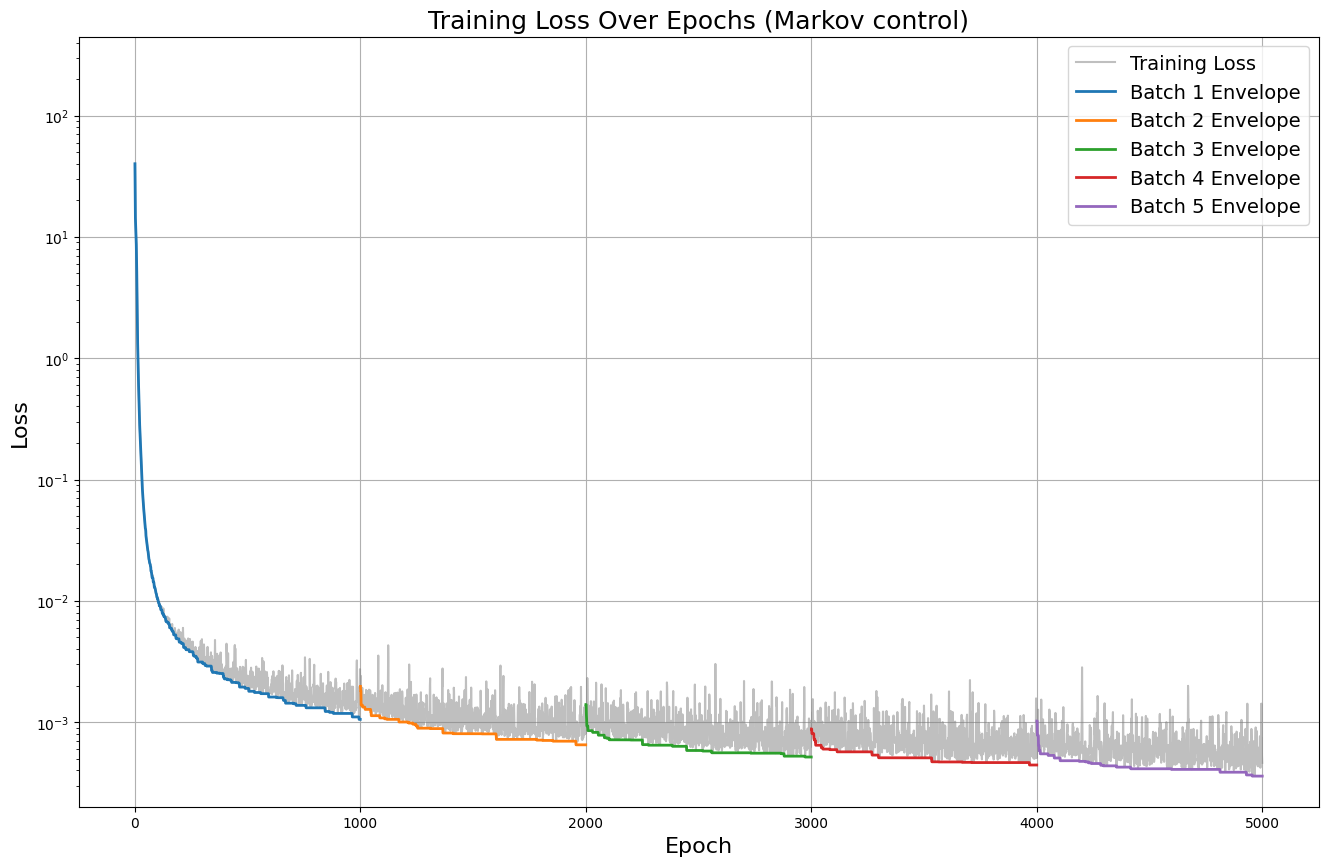

In [10]:
# Plotting the training loss with adjusted y-axis limits

envelope_lower = np.minimum.accumulate(epoch_losses)
plt.figure(figsize=(16, 10))
plt.plot(epoch_losses_control, label='Training Loss', alpha=0.5, color='grey')
epoch_list = range(batch_size*epochs)
for i in range(batch_size):
    start = i * epochs
    end = (i + 1) * epochs
    batch_epochs = epoch_list[start:end]
    batch_losses = epoch_losses_control[start:end]
    
    envelope_lower = np.minimum.accumulate(batch_losses)
    
    plt.plot(batch_epochs, envelope_lower, label=f'Batch {i+1} Envelope',lw=2)


plt.yscale('log')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Training Loss Over Epochs (Markov control)', fontsize=18)
plt.ylim(min(epoch_losses)- 0.01, max(epoch_losses) + 0.01)  # Setting the y-axis limit to better visualize the decrease in loss
plt.legend(fontsize=14)
plt.grid(True)  # Add grid for better readability

plt.savefig('Training Loss (Markov control).eps', format='eps', dpi=600)
plt.savefig('Training Loss (Markov control).png', format='png', dpi=600)

plt.show()

In [ ]:
torch.save(model_control, 'control_model.pth')